In [145]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from datetime import date
from scipy import optimize
from numpy import linalg as LA
import datetime
import pandas as pd
plt.style.use('ggplot')

## Functions

In [146]:
def YTM(r, c, n, DP):
    summy = 0.0
    for i in range(1,n+1):
        summy += (100* c/2) * np.exp(-r * i)
    summy += 100* np.exp(-r * n)
    return summy - DP

def get_bonds(df, bond_times, curr_date, time):
    bond_loc = df['Maturity Date'].isin(bond_times)
    bonds = df[bond_loc][['Maturity Date', 'Coupon', 'Ask']]
    bonds['Dirty Price'] = bonds['Ask'] + 100 * bonds['Coupon']/2 * (time)/(365/2)
    bonds['Months'] = (bonds['Maturity Date'].dt.to_period('M') - curr_date.to_period('M')).apply(lambda x: x.n)
    bonds['Coupon Payments'] = bonds['Months']//6 + 1
    bonds['YTM'] = bonds.apply(lambda x: optimize.newton(YTM, .05, 
                                                                   args = (x['Coupon'], 
                                                                           x['Coupon Payments'],
                                                                           x['Dirty Price'])),  axis = 1)
    return bonds


def bootstrap_spot_rates(data):
    spot_rates = []
    for i in range(1,11):
        if i == 1:
            rate = -1 * np.log(data['Dirty Price'].iloc[0]/ (100 + 100 * data['Coupon'].iloc[0]/2)) / (data['Months'].iloc[0] / 12)
            spot_rates.append(rate)
        else:
            cashflows = 0.0
            period = 1
            while period < i:
                cf = (100 * data['Coupon'].iloc[period-1]/2) * np.exp(spot_rates[period-1] * data['Months'].iloc[period - 1] / 12)
                cashflows += cf
                period+= 1
            rate = -1 * np.log((data['Dirty Price'].iloc[i-1] - cashflows)/ (100 + 100 * data['Coupon'].iloc[i-1]/2)) 
            / (data['Months'].iloc[i-1]/12)
            spot_rates.append(rate)
    return spot_rates
                

def forward_rate(Stn, St, t, n):
    return (Stn - St)/ n
    
def get_future_rates(data):
    forward_rates = [0]
    for i in range(1,5):
        rate = forward_rate(data['Spot Rates'].iloc[1 + 2*i], data['Spot Rates'].iloc[1], data['Months']/12, i)
        forward_rates.append(rate)
    return forward_rates
        

def log_rates(data):
    log_rates = []
    for i in range(0, len(data) - 1):
        rate = np.log(data.iloc[i+1]/data.iloc[i])
        log_rates.append(rate)
    return log_rates
        

def rate_df(data):
    rates = []
    for i in data.columns:
        rate = log_rates(data[i])
        rates.append(rate)
    test_df = pd.DataFrame(rates)
    return test_df



In [147]:
excel_file = pd.ExcelFile('apm466 bond.xlsx')
bond_time = ['3/1/2025', '9/1/2025', '3/1/2026', '9/1/2026', '3/1/2027', '9/1/2027', 
             '3/1/2028', '9/1/2028', '3/1/2029', '9/1/2029']
bond_times = [pd.Timestamp(i) for i in bond_time]
curr = datetime.datetime.now()
curr_date = pd.Timestamp(curr)
date_since_coupon = curr - datetime.datetime(2024, 9, 1)
date_since_coupon = date_since_coupon.days
days = ['Day ' + str(i) for i in range(1,11)]
bond_dic = {}
for day in days:
    data = excel_file.parse(day)
    bond_data = get_bonds(data, bond_times, curr_date, date_since_coupon)
    bond_dic[day] = bond_data
    bond_dic[day] = bond_dic[day].sort_values(by = ['Maturity Date'])
    bond_dic[day] = bond_dic[day].drop_duplicates()
    bond_dic[day] = bond_dic[day].reset_index(drop = True)

In [148]:
bond_dic['Day 1']

,Maturity Date,Coupon,Ask,Dirty Price,Months,Coupon Payments,YTM
0,2025-03-01,0.0125,99.73,100.206027,2,1,0.004172
1,2025-09-01,0.0050,98.43,98.620411,8,2,0.009452
2,2026-03-01,0.0025,96.99,97.085205,14,3,0.011122
3,2026-09-01,0.0100,97.01,97.390822,20,4,0.011647
4,2027-03-01,0.0125,96.7,97.176027,26,5,0.012032
5,2027-09-01,0.0275,99.72,100.76726,32,6,0.012339
6,2028-03-01,0.0350,102.07,103.402877,38,7,0.012319
7,2028-09-01,0.0325,101.41,102.647671,44,8,0.012667
8,2029-03-01,0.0400,104.29,105.813288,50,9,0.013025
9,2029-09-01,0.0350,102.45,103.782877,56,10,0.013343


In [149]:
bond_dic

{'Day 1':   Maturity Date  Coupon     Ask Dirty Price  Months  Coupon Payments       YTM
 0    2025-03-01  0.0125   99.73  100.206027       2                1  0.004172
 1    2025-09-01  0.0050   98.43   98.620411       8                2  0.009452
 2    2026-03-01  0.0025   96.99   97.085205      14                3  0.011122
 3    2026-09-01  0.0100   97.01   97.390822      20                4  0.011647
 4    2027-03-01  0.0125    96.7   97.176027      26                5  0.012032
 5    2027-09-01  0.0275   99.72   100.76726      32                6  0.012339
 6    2028-03-01  0.0350  102.07  103.402877      38                7  0.012319
 7    2028-09-01  0.0325  101.41  102.647671      44                8  0.012667
 8    2029-03-01  0.0400  104.29  105.813288      50                9  0.013025
 9    2029-09-01  0.0350  102.45  103.782877      56               10  0.013343,
 'Day 2':   Maturity Date  Coupon     Ask Dirty Price  Months  Coupon Payments       YTM
 0    2025-03-01  0.0

### Question 4
#### A)

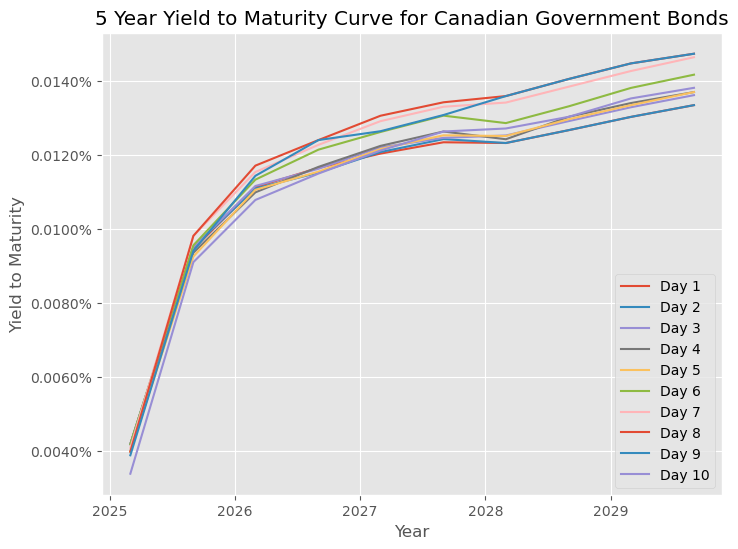

In [150]:
fig, ax = plt.subplots(figsize = (8,6))
for date in bond_dic: 
    ax.plot('Maturity Date', 'YTM', data = bond_dic[date], label = date)
plt.legend()    
ax.set_xlabel('Year')
ax.set_ylabel('Yield to Maturity')
ax.set_title('5 Year Yield to Maturity Curve for Canadian Government Bonds')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

#### B)

In [151]:
for j in bond_dic:
    bond_dic[j]['Spot Rates'] = bootstrap_spot_rates(bond_dic[j])
    print(j + ' done')

Day 1 done
Day 2 done
Day 3 done
Day 4 done
Day 5 done
Day 6 done
Day 7 done
Day 8 done
Day 9 done
Day 10 done


In [152]:
bond_dic['Day 1']

,Maturity Date,Coupon,Ask,Dirty Price,Months,Coupon Payments,YTM,Spot Rates
0,2025-03-01,0.0125,99.73,100.206027,2,1,0.004172,0.025034
1,2025-09-01,0.0050,98.43,98.620411,8,2,0.009452,0.022773
2,2026-03-01,0.0025,96.99,97.085205,14,3,0.011122,0.039951
3,2026-09-01,0.0100,97.01,97.390822,20,4,0.011647,0.041875
4,2027-03-01,0.0125,96.7,97.176027,26,5,0.012032,0.050940
5,2027-09-01,0.0275,99.72,100.76726,32,6,0.012339,0.028559
6,2028-03-01,0.0350,102.07,103.402877,38,7,0.012319,0.020628
7,2028-09-01,0.0325,101.41,102.647671,44,8,0.012667,0.046071
8,2029-03-01,0.0400,104.29,105.813288,50,9,0.013025,0.037042
9,2029-09-01,0.0350,102.45,103.782877,56,10,0.013343,0.080005


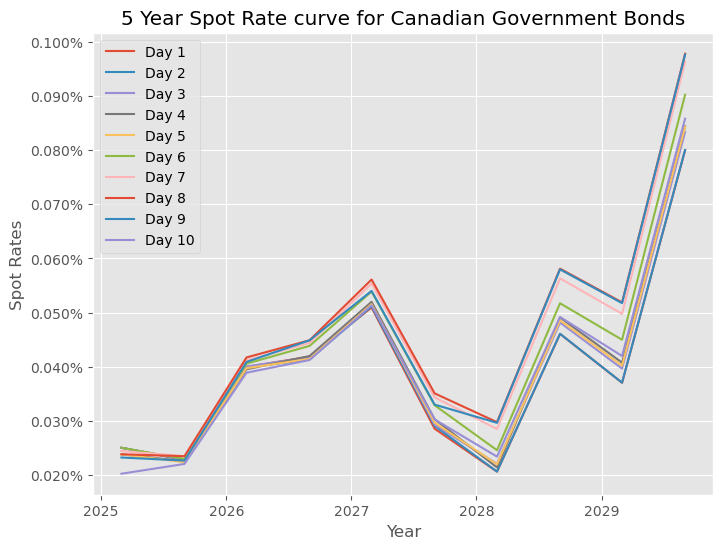

In [153]:
fig, ax = plt.subplots(figsize = (8,6))
for date in bond_dic: 
    ax.plot('Maturity Date', 'Spot Rates', data = bond_dic[date], label = date)
plt.legend()    
ax.set_xlabel('Year')
ax.set_ylabel('Spot Rates')
ax.set_title('5 Year Spot Rate curve for Canadian Government Bonds')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

#### C)

In [154]:
bond_fwd_dic = {}
for j in bond_dic:
    bond_dic[j]['Month'] = bond_dic[j]['Maturity Date'].apply(lambda x: x.month) 
    bond_dic[j]['Years'] = (bond_dic[j]['Maturity Date'].dt.to_period('Y') - curr_date.to_period('Y')).apply(lambda x: x.n)
for j in bond_dic:
    bond_fwd_dic[j] = bond_dic[j][bond_dic[j]['Month'] == 9]
for j in bond_dic:
    bond_fwd_dic[j]['Forward Rate'] = get_future_rates(bond_dic[j])
    print(j + ' done')

Day 1 done
Day 2 done
Day 3 done
Day 4 done
Day 5 done
Day 6 done
Day 7 done
Day 8 done
Day 9 done
Day 10 done


/tmp/ipykernel_53/24121667.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_53/24121667.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_53/24121667.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_53/24121667.py:8

In [155]:
#get_future_rates(bond_dic['Day 6'])

In [156]:
#bond_fwd_dic['Day 6']

In [157]:
#bond_fwd_dic

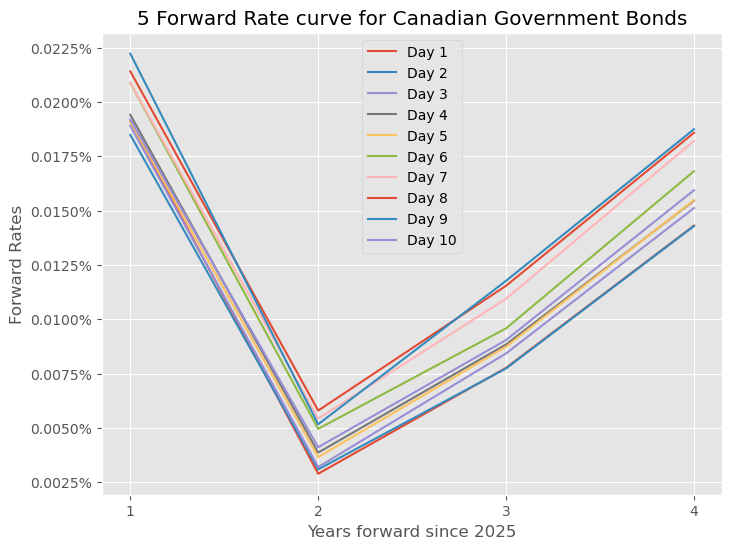

In [158]:
fig, ax = plt.subplots(figsize = (8,6))
for date in bond_fwd_dic: 
    ax.plot('Years', 'Forward Rate', data = bond_fwd_dic[date][1:], label = date)
plt.legend()    
ax.set_xlabel('Years forward since 2025')
ax.set_ylabel('Forward Rates')
ax.set_title('5 Forward Rate curve for Canadian Government Bonds')
ax.xaxis.set_major_locator(mtick.FixedLocator([0,1,2,3,4]))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

## Question 5

In [159]:
#REDO
ytm_df = pd.DataFrame() 
for j in bond_dic:
    var_name = j + ' YTM'
    ytm_df[var_name] = bond_dic[j]['YTM'].values
ytm_df = ytm_df[0:5] #change choice in bonds later
ytm_df = ytm_df.transpose()
ytm_df

,0,1,2,3,4
Day 1 YTM,0.004172,0.009452,0.011122,0.011647,0.012032
Day 2 YTM,0.004172,0.009502,0.011088,0.011518,0.012074
Day 3 YTM,0.004172,0.009502,0.011156,0.011621,0.012199
Day 4 YTM,0.003973,0.009350,0.010985,0.011673,0.012241
Day 5 YTM,0.003973,0.009249,0.011053,0.011544,0.012157
Day 6 YTM,0.004172,0.009553,0.011328,0.012139,0.012616
Day 7 YTM,0.004073,0.009807,0.011535,0.012269,0.012909
Day 8 YTM,0.003973,0.009807,0.011707,0.012398,0.013056
Day 9 YTM,0.003873,0.009401,0.011432,0.012398,0.012637
Day 10 YTM,0.003374,0.009096,0.010778,0.011492,0.012115


In [160]:
ytm_cov_df = rate_df(ytm_df)
ytm_cov_df = pd.DataFrame(np.cov(ytm_cov_df))
print(ytm_cov_df.style.to_latex())

\begin{tabular}{lrrrrr}
 & 0 & 1 & 2 & 3 & 4 \\
0 & 0.002581 & 0.000807 & 0.001142 & 0.001485 & 0.000953 \\
1 & 0.000807 & 0.000607 & 0.000531 & 0.000543 & 0.000580 \\
2 & 0.001142 & 0.000531 & 0.000675 & 0.000744 & 0.000592 \\
3 & 0.001485 & 0.000543 & 0.000744 & 0.001105 & 0.000698 \\
4 & 0.000953 & 0.000580 & 0.000592 & 0.000698 & 0.000630 \\
\end{tabular}



In [161]:
ytm_eigval, ytm_eigvec = LA.eig(ytm_cov_df)
ytm_sum = sum(ytm_eigval)

ytm_eigval_perc = ytm_eigval/ytm_sum
ytm_eigval_perc_df = pd.DataFrame(ytm_eigval_perc).transpose()
ytm_ev_df = pd.DataFrame(ytm_eigvec)
ytm_eig_df = pd.DataFrame(ytm_eigval).transpose()


ytm_final = pd.concat([ytm_eig_df,ytm_eigval_perc_df, ytm_ev_df], ignore_index = True)

In [162]:
print(ytm_final.style.format(precision = 10).to_latex())

\begin{tabular}{lrrrrr}
 & 0 & 1 & 2 & 3 & 4 \\
0 & 0.0048541591 & 0.0004936754 & 0.0001800884 & 0.0000579110 & 0.0000121406 \\
1 & 0.8671277582 & 0.0881882137 & 0.0321702846 & 0.0103449874 & 0.0021687561 \\
2 & -0.7030568205 & -0.5500461761 & 0.4095268872 & 0.1662735997 & 0.0883240062 \\
3 & -0.2786620452 & 0.6340638415 & 0.3413930691 & 0.3574758974 & -0.5253306240 \\
4 & -0.3526678330 & 0.2145081336 & 0.0736862976 & -0.9000635020 & -0.1186072601 \\
5 & -0.4484298243 & -0.0548935202 & -0.8360315058 & 0.1313789313 & -0.2822911473 \\
6 & -0.3203040180 & 0.4963720491 & -0.1065840133 & 0.1311081295 & 0.7889680801 \\
\end{tabular}



#### Forward Rate Q5

In [163]:
fwd_rate_df = pd.DataFrame()
for j in bond_fwd_dic:
    var_name = j + ' FWD Rate'
    fwd_rate_df[var_name] = bond_fwd_dic[j]['Forward Rate'].values
    
fwd_rate_df = fwd_rate_df[1:]
#fwd_rate_df = fwd_rate_df.transpose()
fwd_rate_df

,Day 1 FWD Rate,Day 2 FWD Rate,Day 3 FWD Rate,Day 4 FWD Rate,Day 5 FWD Rate,Day 6 FWD Rate,Day 7 FWD Rate,Day 8 FWD Rate,Day 9 FWD Rate,Day 10 FWD Rate
1,0.019102,0.018482,0.018897,0.019409,0.019094,0.020873,0.020884,0.021405,0.022219,0.019191
2,0.002893,0.003095,0.003203,0.003867,0.003658,0.004959,0.005433,0.005799,0.005169,0.004112
3,0.007766,0.007739,0.008429,0.008842,0.008737,0.009583,0.010944,0.011542,0.011771,0.009047
4,0.014308,0.014289,0.015117,0.015455,0.015481,0.016815,0.018209,0.018581,0.018744,0.015938


In [164]:
fwd_cov_df =  pd.DataFrame(np.cov(fwd_rate_df))
fwd_eigval, fwd_eigvec = LA.eig(fwd_cov_df)
fwd_sum = sum(fwd_eigval)

fwd_eigval_perc = fwd_eigval/fwd_sum
fwd_eigval_perc_df = pd.DataFrame(fwd_eigval_perc).transpose()
fwd_ev_df = pd.DataFrame(fwd_eigvec)
fwd_eig_df = pd.DataFrame(fwd_eigval).transpose()


fwd_final = pd.concat([fwd_eig_df,fwd_eig_perc_df, fwd_ev_df], ignore_index = True)

In [165]:
print(fwd_final)

          0             1             2             3
0  0.000008  1.439796e-07  7.506321e-08  6.121923e-09
1  0.971205  1.841244e-02  9.599249e-03  7.828850e-04
2  0.445797  8.524564e-01  2.723103e-01 -2.075042e-02
3  0.368180 -4.449166e-01  7.692060e-01 -2.735225e-01
4  0.535734 -1.199009e-01 -5.496801e-01 -6.296548e-01
5  0.615385 -2.469638e-01 -1.789442e-01  7.268353e-01


In [166]:
print(fwd_cov_df.style.to_latex())

\begin{tabular}{lrrrr}
 & 0 & 1 & 2 & 3 \\
0 & 0.000002 & 0.000001 & 0.000002 & 0.000002 \\
1 & 0.000001 & 0.000001 & 0.000001 & 0.000002 \\
2 & 0.000002 & 0.000001 & 0.000002 & 0.000003 \\
3 & 0.000002 & 0.000002 & 0.000003 & 0.000003 \\
\end{tabular}



In [167]:
print(fwd_final.style.format(precision = 10).to_latex())

\begin{tabular}{lrrrr}
 & 0 & 1 & 2 & 3 \\
0 & 0.0000075945 & 0.0000001440 & 0.0000000751 & 0.0000000061 \\
1 & 0.9712054302 & 0.0184124358 & 0.0095992490 & 0.0007828850 \\
2 & 0.4457966379 & 0.8524563797 & 0.2723102980 & -0.0207504221 \\
3 & 0.3681803210 & -0.4449165826 & 0.7692060252 & -0.2735225339 \\
4 & 0.5357335075 & -0.1199008694 & -0.5496800541 & -0.6296548488 \\
5 & 0.6153846097 & -0.2469638371 & -0.1789442107 & 0.7268353423 \\
\end{tabular}



## Below is unused parts of the template

## Template Bootstrap Function

In [168]:
def bootstrap_yield_curve(bonds):
    spot_rates = np.zeros(len(bonds))

    for i, (price, coupon_rate, maturity) in enumerate(sorted(bonds, key=lambda x: x[2])):
        cash_flows = np.array([coupon_rate] * int(maturity - 1) + [100 + coupon_rate])
        time_periods = np.arange(1, maturity + 1)
        # Use previously calculated spot rates for discounted cash flows
        if i == 0:
            discounted_cash_flows = cash_flows / (1 + spot_rates[i])**time_periods
        else:
            discounted_cash_flows = [cf / (1 + spot_rates[j])**time_periods[j] for j, cf in enumerate(cash_flows)]
            discounted_cash_flows = np.sum(discounted_cash_flows)

        residual = price - discounted_cash_flows
        if residual <= 0:
            # Handle cases where residual is too low
            print(f"Warning: Residual for bond with maturity {maturity} is too low. Adjusting spot rate calculation.")
            spot_rate = spot_rates[i-1]  # Use previous spot rate as an approximation
        else:
            spot_rate = ((100 / residual)**(1 / maturity)) - 1
        spot_rates[i] = spot_rate

    return spot_rates

## Example Bond

In [169]:
bonds = [
    (195, 1, 1),
    (190, 1.5, 2),
    (188, 2, 3)
]

## Bootstrapping spot rates

In [170]:
spot_rates = bootstrap_yield_curve(bonds)
print("Spot Rates:", spot_rates)


Spot Rates: [0.06382979 0.07155842 0.06674979]


## Plotting the yield curve

In [171]:
maturities = [bond[2] for bond in bonds]
fig = go.Figure(go.Scatter(x=maturities, y=spot_rates * 100, mode='lines+markers'))
fig.update_layout(title='Bootstrapped Yield Curve', xaxis_title='Maturity (Years)', yaxis_title='Spot Rate (%)')
fig.show()